In [73]:
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
import unicodedata
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import pandas as pd
import numpy as np
import nltk
import gensim
import unicodedata
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import word_tokenize, pos_tag,pos_tag_sents
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD as svd
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin 
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfTransformer

In [74]:
# Loading the data, changing date format, removing duplicates and checking average rating

reviews = pd.read_csv('https://raw.githubusercontent.com/AkhilRD/Text-Analytics/main/uber_reviews_itune.csv',encoding = "cp1252")
reviews['Date'] = pd.to_datetime(reviews['Date'])
reviews.drop_duplicates(subset=None,keep='first',inplace=True)
print(reviews.info())
print(reviews.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 489
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Author_Name  489 non-null    object        
 1   Title        489 non-null    object        
 2   Author_URL   489 non-null    object        
 3   App_Version  489 non-null    object        
 4   Rating       489 non-null    int64         
 5   Review       489 non-null    object        
 6   Date         489 non-null    datetime64[ns]
 7   Time         489 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 34.4+ KB
None
           Rating
count  489.000000
mean     1.503067
std      1.010443
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max      5.000000


In [75]:
# Combining title and reviews columns

reviews['full_review'] = reviews['Title'] + " " + reviews['Review']
# reviews["full_review"] =  reviews.full_review.str.replace('[^\x00-\x7F]','')
reviews.full_review

0      Dishonest and Disgusting For half an hour, we ...
1      Free offer If I’m not eligible for the offer S...
2      Inaccurate Consistently inaccurate Uber Eats E...
3      bad i had my rides canceled back to back. they...
4      Double charged me for an order Two of the same...
                             ...                        
485    Uber Perdí mi cuenta no la puedo recuperar la ...
486    Crap crap crap Still the same. I was forced to...
487    Sleeping Drivers It is a 30 minute commute fro...
488    Bad design re: offer code redemption and issue...
489    I’m sick of Uber At first Uber was okay but th...
Name: full_review, Length: 489, dtype: object

# <font color=#191970> 1. Pre-processing:

In [76]:
def preprocessing(text):
    stop = nltk.corpus.stopwords.words('english')
    lem = WordNetLemmatizer()
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [lem.lemmatize(w) for w in words if w not in stop]


In [77]:
reviews['words']=reviews.apply(lambda x: preprocessing(x['full_review']), axis=1)
def final(lem_col):
    return (" ".join(lem_col))

reviews['words'] = reviews.apply(lambda x: final(x['words']),axis=1)
reviews['words']

0      dishonest disgusting half hour tried every ube...
1      free offer im eligible offer stop flooding ema...
2      inaccurate consistently inaccurate uber eats e...
3      bad ride canceled back back still charged acco...
4      double charged order two order added accident ...
                             ...                        
485    uber perdi mi cuenta la puedo recuperar la use...
486    crap crap crap still forced use colombia since...
487    sleeping driver 30 minute commute household wo...
488    bad design offer code redemption issue resolut...
489    im sick uber first uber okay thing started hap...
Name: words, Length: 489, dtype: object

In [78]:
words = preprocessing(''.join(str(reviews['full_review'].tolist())))
words

['dishonest',
 'disgusting',
 'half',
 'hour',
 'tried',
 'every',
 'uber',
 'service',
 'take',
 'short',
 'trip',
 'uber',
 'falsely',
 'advertised',
 'dropoffs',
 'certain',
 'time',
 'deliver',
 'finally',
 'downloded',
 'lyft',
 'immediately',
 'got',
 'car',
 'two',
 'minute',
 'away',
 'free',
 'offer',
 'im',
 'eligible',
 'offer',
 'stop',
 'flooding',
 'email',
 'false',
 'information',
 'u0001f621u0001f621u0001f621',
 'inaccurate',
 'consistently',
 'inaccurate',
 'uber',
 'eats',
 'eta',
 'food',
 'menu',
 'often',
 'error',
 'bad',
 'ride',
 'canceled',
 'back',
 'back',
 'still',
 'charged',
 'account',
 'cancellation',
 'fee',
 'tried',
 'get',
 'money',
 'back',
 'gave',
 'money',
 'app',
 'want',
 'money',
 'back',
 'card',
 'also',
 'wasnt',
 'able',
 'get',
 'touch',
 'help',
 'uber',
 'terrible',
 'double',
 'charged',
 'order',
 'two',
 'order',
 'added',
 'accident',
 'restaurant',
 'tried',
 'remove',
 'order',
 'couldnt',
 'tried',
 'reaching',
 'uber',
 'eats',

# <font color=#191970> 2. Basic text and sentiment analysis:

In [79]:
# Bigrams

bigram = (pd.Series(nltk.ngrams(words,2)).value_counts())[:13]
bigram

(customer, service)    77
(use, uber)            32
(uber, driver)         28
(uber, pas)            27
(uber, eats)           26
(payment, method)      23
(customer, support)    21
(uber, app)            19
(minute, away)         18
(credit, card)         18
(get, ride)            18
(use, lyft)            18
(every, time)          17
dtype: int64

<AxesSubplot:>

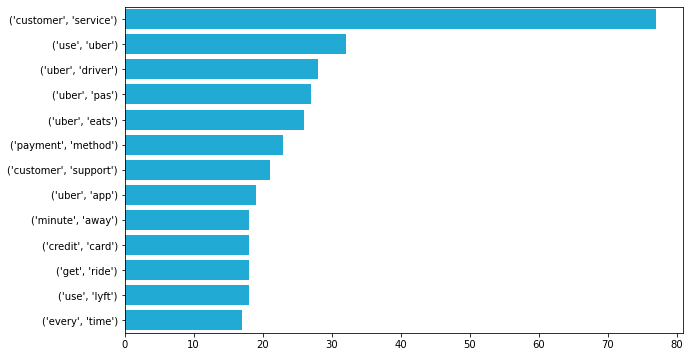

In [80]:
plt.figure(figsize=(10,6)) 
sns.barplot(bigram.values,bigram.index,orient="h",color="#04BAF0")

In [81]:
# Trigrams

trigram = (pd.Series(nltk.ngrams(words,3)).value_counts())[:10]
trigram

(horrible, customer, service)    7
(worst, customer, service)       6
(uber, credit, card)             5
(terrible, customer, service)    5
(charged, uber, pas)             5
(get, money, back)               5
(want, money, back)              5
(customer, service, app)         4
(poor, customer, service)        4
(20, minute, away)               4
dtype: int64

<AxesSubplot:>

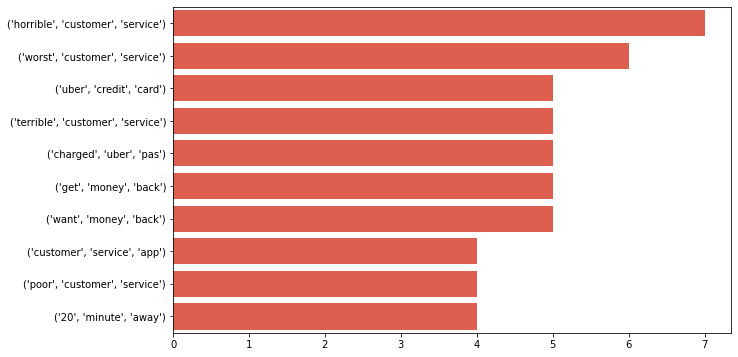

In [82]:
#trigram.plot.barh()
plt.figure(figsize=(10,6)) 
sns.barplot(trigram.values,trigram.index,orient="h",color="#F34D39")


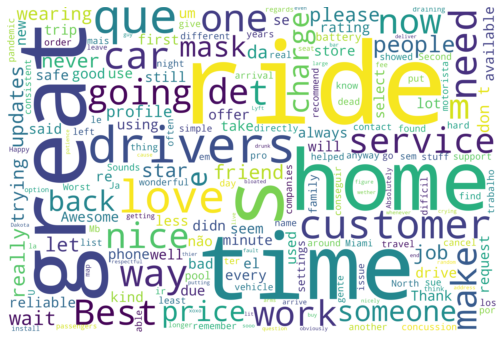

In [83]:
# Rating greater than or equal to 4

high_rating = reviews[reviews['Rating'] >= 4]
stop_words = ["Uber", "app",'driver'] + list(STOPWORDS)

text = high_rating.full_review.tolist() 
text = ' '.join(text)

wordcloud = WordCloud(stopwords = stop_words,background_color='white',width= 3000, height = 2000,
                      collocations=True).generate(text)
plt.figure(figsize=(10,6)) 
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

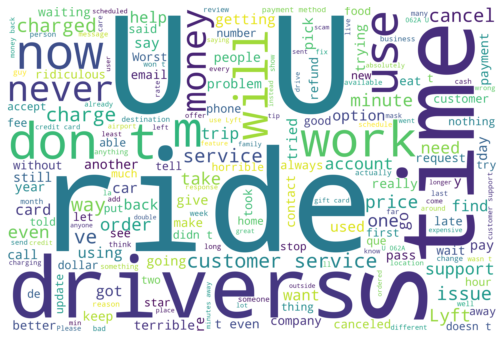

In [84]:
# Rating less than or equal to 3

high_rating = reviews[reviews['Rating'] <= 3]
stop_words = ["Uber", "app",'driver'] + list(STOPWORDS)

text = high_rating.full_review.tolist() 
text = ' '.join(text)

wordcloud = WordCloud(stopwords = stop_words,background_color='white',width= 3000, height = 2000,
                      collocations=True).generate(text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

# <font color=#191970> 3. Feature construction and extraction:

In [56]:
#Sentiment Scores

sent_analyzer = SentimentIntensityAnalyzer()
cs = []
def senti(text):
    for row in range(len(reviews)):
        cs.append(sent_analyzer.polarity_scores((text).iloc[row])['compound'])

senti(reviews['words'])
reviews['sentiment_score'] = cs
reviews = reviews[(reviews[['sentiment_score']] != 0).all(axis=1)].reset_index(drop=True)
reviews['sentiment_score']

0     -0.7184
1      0.2732
2     -0.4019
3     -0.6901
4     -0.5983
        ...  
437   -0.2575
438   -0.5574
439   -0.5209
440   -0.7605
441   -0.9577
Name: sentiment_score, Length: 442, dtype: float64

In [58]:
#Sentiment score by rating

reviews.groupby("Rating").agg({"sentiment_score":"mean"})

,sentiment_score
Rating,
1,-0.192494
2,-0.128271
3,0.210267
4,0.174200
5,0.843187


In [59]:
#Median word count by rating

word_count= reviews['full_review'].apply(lambda x: len(str(x).split(" ")))
reviews['word_count'] = word_count
reviews.groupby("Rating").agg({"word_count":"median"})

,word_count
Rating,
1,54.5
2,60.0
3,56.0
4,51.0
5,44.5


- We can see the sentiment scores are positive from a rating 3 and above.
- People leaving a negative rating tend to write longer reviews to communicate their issues with the product/service. That is what we witness here looking at the word count grouped by rating.

# <font color=#191970> 4. Supervised Learning phase:

In [60]:
reviews['binary'] = np.where(reviews['Rating'] >= 3, 1, 0)
reviews.head()

,Author_Name,Title,Author_URL,App_Version,Rating,Review,Date,Time,full_review,words,sentiment_score,word_count,binary
0,#NEVERUBER,Dishonest and Disgusting,https://itunes.apple.com/us/reviews/id663331949,3.434.10005,1,"For half an hour, we tried EVERY UBER SERVICE ...",2020-12-29,1:14:00,"Dishonest and Disgusting For half an hour, we ...",dishonest disgusting half hour tried every ube...,-0.7184,43,0
1,$$Heaven,Free offer,https://itunes.apple.com/us/reviews/id810421958,3.434.10005,2,If I’m not eligible for the offer Stop floodin...,2021-01-01,11:17:00,Free offer If I’m not eligible for the offer S...,free offer im eligible offer stop flooding ema...,0.2732,18,0
2,.Disappointed....,Inaccurate,https://itunes.apple.com/us/reviews/id49598333,3.439.10000,2,Consistently inaccurate Uber Eats ETA and the ...,2021-01-15,11:38:00,Inaccurate Consistently inaccurate Uber Eats E...,inaccurate consistently inaccurate uber eats e...,-0.4019,13,0
3,.i. andrea,bad,https://itunes.apple.com/us/reviews/id689880334,3.434.10005,1,i had my rides canceled back to back. they the...,2020-08-12,1:01:00,bad i had my rides canceled back to back. they...,bad ride canceled back back still charged acco...,-0.6901,58,0
4,-:deka:-,Double charged me for an order,https://itunes.apple.com/us/reviews/id124963835,3.434.10005,1,Two of the same orders was added by accident. ...,2020-12-15,4:02:00,Double charged me for an order Two of the same...,double charged order two order added accident ...,-0.5983,97,0


In [61]:
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,1))
vectorizer = count_vectorizer.fit_transform(reviews.words)

In [62]:
tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=False).fit_transform(vectorizer)


In [63]:
y = reviews['binary']
X_train,X_test, y_train, y_test = train_test_split(tf_transformer,y,
                                                   test_size=0.25,random_state=52)

In [64]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)

# Fit the classifier to the training data
mlp_classifier.fit(X_train,y_train)

# Create the predicted tags: pred
pred = mlp_classifier.predict(X_test)
pred

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1])

In [65]:
from sklearn import metrics

# Calculate the confusion matrix: cm

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements
cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])
print(accuracy(cm))

0.8018018018018018


In [66]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
pred2 = model.predict(X_test)
cm = metrics.confusion_matrix(y_test,pred2,labels=[0,1])
print(accuracy(cm))

0.8738738738738738


In [68]:
#creating array variable of all the words

feature_names = np.array(count_vectorizer.get_feature_names())

#creating array of all the regression coefficients per word

coef_index = model.coef_[0]

#creating df with both arrays in it

df = pd.DataFrame({'Word':feature_names, 'Coef': coef_index})

#sorting by coefficient


print("Positive Words:")
print(df.sort_values('Coef',ascending= False)[:15])
print(" ")
print("Negative Words:")
print(df.sort_values('Coef',ascending= True)[:15])


Positive Words:
         Word      Coef
1118    great  1.494253
1451     love  1.058042
340   awesome  0.946296
2661     wait  0.833077
834    driver  0.816896
1195     home  0.769993
1590     need  0.723091
472       car  0.693962
379      best  0.693445
1108     good  0.614308
1599     nice  0.582359
1104    going  0.550039
1857  profile  0.539401
2461     time  0.535249
1445      los  0.451146
 
Negative Words:
          Word      Coef
473       card -0.648946
2369   support -0.631396
1556     money -0.590819
2611       use -0.570935
2426  terrible -0.537863
1205  horrible -0.508317
506    charged -0.497736
2510      trip -0.461530
1716   payment -0.418944
1624    number -0.414729
1178      help -0.413655
2735     worst -0.386954
616    contact -0.367929
2177   service -0.337971
2062    review -0.329748


<font color = #191970> Let us run the model and check the kind of output it predicts

In [27]:
print(model.predict(count_vectorizer.transform(['I think I had a good trip. The driver was helpful but the charge for the trip was huge'])))

[0]


In [28]:
print(model.predict(count_vectorizer.transform(['Just loved the experience of Uber.'])))

[0]


In [29]:
print(model.predict(count_vectorizer.transform(['abandoned great'])))

[0]


In [30]:
print(model.predict(count_vectorizer.transform(['love great map'])))

[1]


<font color = #191970> 
   Based on our confusion matrix, we see that there is 80% accuracy of our model. We can see here that there is cleary a bias towards the negative ratings. Even using a decent review, we get low ratings. This can be accounted for by the skewness of our dataset towards negative ratings and the fact that we need to work with Uber Inc. to fix the flaws in their service based on these results.

# <font color=#191970> 5. Conclusion and Recommendations:

<font color = #191970> 
We can see the top 15 negative words in our last chunk of codes. These words are the most negatively correlated with the sentiment and have the highest impact on our reviews.
That means we can now go back to Uber Inc. and tell them where they need to improve in terms of Customer service.
    
Let us pick a few words which make sense and make resonable recommendations based on that
    
   <font color = #191970>  1. Card - Since it is the most negatively coefficient word, it needs the utmost attention. Customers are mentioning this most of the time in their reviews with low ratings. There seems to be a problem with Uber not accepting card, card declining at the time of payment, not accepting all type of cards (Visa, MC, AmEx). 

   <font color = #191970> We recommend that Uber Inc. looks are the process of streamlining the payment process where Customers are paying via Card. 
       
   <font color = #191970> 2.  Support - This comes next after card which means Customers are looking to conect with Uber support team and are probably not getting the adequate response.
       
   <font color = #191970> We recommend that Uber Inc. puts most of their efforts in building a fully functioning support team, which can troubleshoot Customer queries effortlessly. 
       
   <font color = #191970> 3. Money - As is clear from the negative coefficient, and from the trigrams earlier, Customers are not satisfied the the experience and want their money back. A lot of things about their journey didn't add up to their expectation and thus they are resorting to asking for a refund
       
   <font color = #191970> We suggest that Uber goes back to the drawing board and chalk up new ideas to make the journey impactful and worthy of the trip charged to the Customer.
       
   <font color = #191970> 4. Charged - Another interesting negative sentiment word in the top 10 which most likely refers to customers being unhappy with the fare costs/receiving end of surge pricing.
       
       
   <font color = #191970> In conclusion Uber based on the given reviews has troubles associated with payments and customer service. A few ways to improve:
       
   <font color = #191970> - Integrate payment systems with much more efficiency/Uber has to partner with better payments provider.
       
   <font color = #191970> - Built a robust customer care solution systems so Uber's passengers have their queries solved faster and efficiently.

Streamlit URL:

https://akhilrd-text-analytics-stream-kvzrpt.streamlitapp.com/